# Compare with DAI composition

In [1]:
from pathlib import Path
from datetime import datetime
from enum import Enum

import matplotlib.pyplot as plt
import matplotlib.transforms as transforms
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import multivariate_t, norm, t
import numpy as np
from scipy import special
from pypfopt import (
    EfficientFrontier,
    EfficientSemivariance,
    EfficientCVaR,
    expected_returns,
    risk_models,
    plotting, # Need to fix bug in the library
)

def set_style(size=(12, 9)):
    sns.set(rc={'figure.figsize':size})
    sns.set_style("whitegrid")

set_style()

# Monte carlo: https://github.com/GreatSoshiant/Monte-Carlo/blob/master/Code/Monte-Carlo.py


data_folder = Path("../data")

class DataType(Enum):
    MINUTE = 1  # Minute data collected by Daniel
    HOUR = 2    # Hour data from the cryptodatadownload.com

# Pick data you want to use:
SELECTED_DATA = DataType.HOUR

/tmp/ipykernel_1686/2215027528.py:8: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# Mapping symbol to tags
symbol_tags = {}
symbols = []
with (data_folder / "symbolTags.txt").open() as f:
    for line in f:
        symbol, tags = line.strip().split(":")
        symbol_tags[symbol] = tags.split(",")
        symbols.append(symbol)

# print(symbol_tags)

names = []
with (data_folder / "nameTags.txt").open() as f:
    for line in f:
        name, _ = line.strip().split(":")
        names.append(name)

symbol_to_name = dict(zip(symbols, names))

# Mapping tags to symbol
tag_groups = {}
for symbol, tags in symbol_tags.items():
    for tag in tags:
        if tag not in tag_groups:
            tag_groups[tag] = []
        tag_groups[tag].append(symbol)

print(tag_groups["mineable"])
print("Stable coins:", tag_groups["stablecoin"])

['BTC', 'ETH', 'ADA', 'DOGE', 'ETC', 'LTC', 'XMR', 'BCH', 'FIL', 'BSV', 'HNT', 'ZEC', 'STX', 'ZIL', 'DASH', 'BTG', 'DCR', 'RVN']
Stable coins: ['USDT', 'USDC', 'BUSD', 'DAI', 'TUSD', 'USDP', 'USDD', 'USDN', 'FEI']


In [3]:
def calcualte_log_returns(array):
    """Calculate log returns of given list/ndarray/pd.Series."""
    return np.diff(np.log(array), axis=0)


def filter_returns(prices, returns):
    # Filter out returns which are for longer time periods than 6 minutes (there are some time jumps in data)
    t_delta = pd.Timedelta(6, "m") if SELECTED_DATA == DataType.MINUTE else pd.Timedelta(1.5, "hour")
    return returns[np.diff(prices.index) < t_delta]

### Hour Price Data

In [4]:
symbols = [
    'aave', 'bal', 'bat', 'comp', 'gno', 'knc', 'link', 'lrc', 'mana',
    'matic', 'uni', 'yfi', 'zrx', 'eth', 'btc'
]
symbols = [s.upper() for s in symbols]
symbols

['AAVE',
 'BAL',
 'BAT',
 'COMP',
 'GNO',
 'KNC',
 'LINK',
 'LRC',
 'MANA',
 'MATIC',
 'UNI',
 'YFI',
 'ZRX',
 'ETH',
 'BTC']

In [5]:
def get_hour_data():
    dfs = []
    columns = [
        "open time", "open", "high", "low", "close", "volume", "close time", "quote asset volume",
        "number of trades", "tb base asset volume", "tb quote asset volume", "ignore",
    ]
    for symbol in symbols:
        p = data_folder / f"dump/spot/monthly/klines/{symbol}USDT/1h"

        if not p.exists():
            continue

        df = pd.concat([pd.read_csv(data_file, names=columns) for data_file in p.glob("*.csv")])
        df.index = pd.to_datetime(df["close time"], unit='ms')
        df = df.sort_index()
        if df.index.min() > datetime(2020, 1, 1,):
            continue
        print(symbol, df.index.min(), df.index.max())
        # Remove duplicated indexes
        df = df[~df.index.duplicated()]

        # Reindex and interpolate with cubicspline as an example
        df = df.reindex(pd.date_range(df.index.min(), df.index.max(), freq='h'))
        df[symbol] = df.close
        dfs.append(df[[symbol]])

    min_d = max(d.index.min() for d in dfs)
    max_d = min(d.index.max() for d in dfs)
    print(f"Data start date {min_d} - end date {max_d}")

    prices = pd.concat([d.loc[min_d:max_d] for d in dfs], axis=1)
    prices = prices.fillna(method="ffill")
    # errors=ignore - skips if axis doesn't exists
    # df = df.drop(tag_groups["stablecoin"] + ["AXG"], axis=1, errors='ignore')
    log_returns = pd.DataFrame(calcualte_log_returns(prices), columns=prices.columns)
    log_returns = filter_returns(prices, log_returns)

    returns = filter_returns(prices, expected_returns.returns_from_prices(prices))
    return prices, returns, log_returns

### Price Data


In [6]:
def get_minute_data():
    dfs = []
    for data_file in data_folder.glob("*.csv"):
        dfs.append(pd.read_csv(data_file))
    data = pd.concat(dfs)

    # Some basic ordering and converting time
    data = data.sort_values("time").reset_index(drop=True)
    data["time"] = pd.to_datetime(data["time"], unit="ms")
    # Filter out wrong timestamps (there is only 2)
    data = data[data["time"].dt.year < 2024]

    # For each symbol create column of prices (index is time)
    prices = data.set_index(["time", "symbol"])["price"].unstack(level=-1)

    log_returns = pd.DataFrame(calcualte_log_returns(prices), columns=prices.columns)
    log_returns = filter_returns(prices, log_returns)
    print("Original len", len(log_returns))

    returns = filter_returns(prices, expected_returns.returns_from_prices(prices))
    return prices, returns, log_returns

In [7]:
def remove_stablecoins(data_frame):
    return data_frame.drop(tag_groups["stablecoin"] + ["PAXG"], axis=1, errors='ignore')

In [8]:
if SELECTED_DATA == DataType.MINUTE:
    FREQUENCY = 365 * 24 * 60 // 5
    DAILY_FREQUENCY = 24 * 60 // 5
    TIME_STEP = pd.Timedelta(5, "m")

    prices, returns, log_returns = get_minute_data()

else:
    FREQUENCY = 365 * 24
    DAILY_FREQUENCY = 24
    TIME_STEP = pd.Timedelta(60, "m")

    prices, returns, log_returns = get_hour_data()

# Remvoe stable coin tokens
prices = remove_stablecoins(prices)
returns = remove_stablecoins(returns)
log_returns = remove_stablecoins(log_returns)

print("Frequency:", FREQUENCY)
print("Total time lenght:", len(returns) * TIME_STEP)
returns.describe()

BAT 2019-03-04 10:59:59.999000 2024-01-31 23:59:59.999000
LINK 2019-01-16 10:59:59.999000 2024-01-31 23:59:59.999000
MATIC 2019-04-26 15:59:59.999000 2024-01-31 23:59:59.999000
ZRX 2019-02-28 04:59:59.999000 2024-01-31 23:59:59.999000
ETH 2017-08-17 04:59:59.999000 2024-01-31 23:59:59.999000
BTC 2017-08-17 04:59:59.999000 2024-01-31 23:59:59.999000
Data start date 2019-04-26 15:59:59.999000 - end date 2024-01-31 23:59:59.999000
Frequency: 8760
Total time lenght: 1741 days 08:00:00


/tmp/ipykernel_1686/2091161679.py:32: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  prices = prices.fillna(method="ffill")


,BAT,LINK,MATIC,ZRX,ETH,BTC
count,41792.000000,41792.000000,41792.000000,41792.000000,41792.000000,41792.000000
mean,0.000064,0.000172,0.000247,0.000099,0.000106,0.000077
std,0.012369,0.013209,0.016197,0.013823,0.009064,0.007383
min,-0.270877,-0.230488,-0.493372,-0.329288,-0.208728,-0.182115
25%,-0.005160,-0.005427,-0.005738,-0.005397,-0.003238,-0.002492
50%,0.000000,0.000000,0.000000,0.000000,0.000056,0.000063
75%,0.005284,0.005568,0.005741,0.005595,0.003483,0.002656
max,0.256610,0.543399,0.355202,0.276038,0.150072,0.173840


## DAI Composition

In [45]:
dai_data = pd.read_csv("../data/dai/collateral_values_combined.csv")
dai_data.index = pd.to_datetime(dai_data["time"], unit="s")
dai_data = dai_data.drop(["time"], axis=1)
print(dai_data.describe())

eth_cols = ["eth_a", "eth_b", "eth_c", "reth", "wsteth_a", "wsteth_b"]
dai_data["eth"] = dai_data[eth_cols].sum(axis=1)
dai_data = dai_data.drop(eth_cols, axis=1)

dai_data = dai_data.drop([c for c in dai_data.columns if "rwa" in c], axis=1)

btc_cols = ["wbtc_a", "wbtc_b", "wbtc_c"]
dai_data["btc"] = dai_data[btc_cols].sum(axis=1)
dai_data = dai_data.drop(btc_cols, axis=1)
dai_data.info()

               aave           bal           bat          comp         eth_a  \
count  7.790000e+02  7.790000e+02  7.790000e+02  7.790000e+02  7.790000e+02   
mean   1.608091e+05  3.065604e+05  1.881044e+06  1.285895e+06  2.445399e+09   
std    2.151739e+05  5.644275e+05  3.395767e+06  5.716836e+06  2.605325e+09   
min    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
25%    0.000000e+00  1.273817e+04  1.690152e+04  2.658924e+04  7.486804e+08   
50%    0.000000e+00  7.699671e+04  2.871334e+04  9.439509e+04  9.741659e+08   
75%    2.743988e+05  3.186990e+05  1.522889e+06  2.293902e+05  4.648907e+09   
max    1.170358e+06  4.699874e+06  1.427016e+07  4.022167e+07  1.090126e+10   

              eth_b         eth_c           gno           knc          link  \
count  7.790000e+02  7.790000e+02  7.790000e+02    779.000000  7.790000e+02   
mean   1.110371e+08  8.449784e+08  4.559118e+06   3857.497433  5.751226e+07   
std    9.122165e+07  6.973213e+08  1.336507e+07   6

/tmp/ipykernel_1686/300665764.py:3: RuntimeWarning: invalid value encountered in divide
  plt.stackplot(data.index, (data.values / np.expand_dims(data.values.sum(axis=1), axis=-1)).T, labels=data.columns)


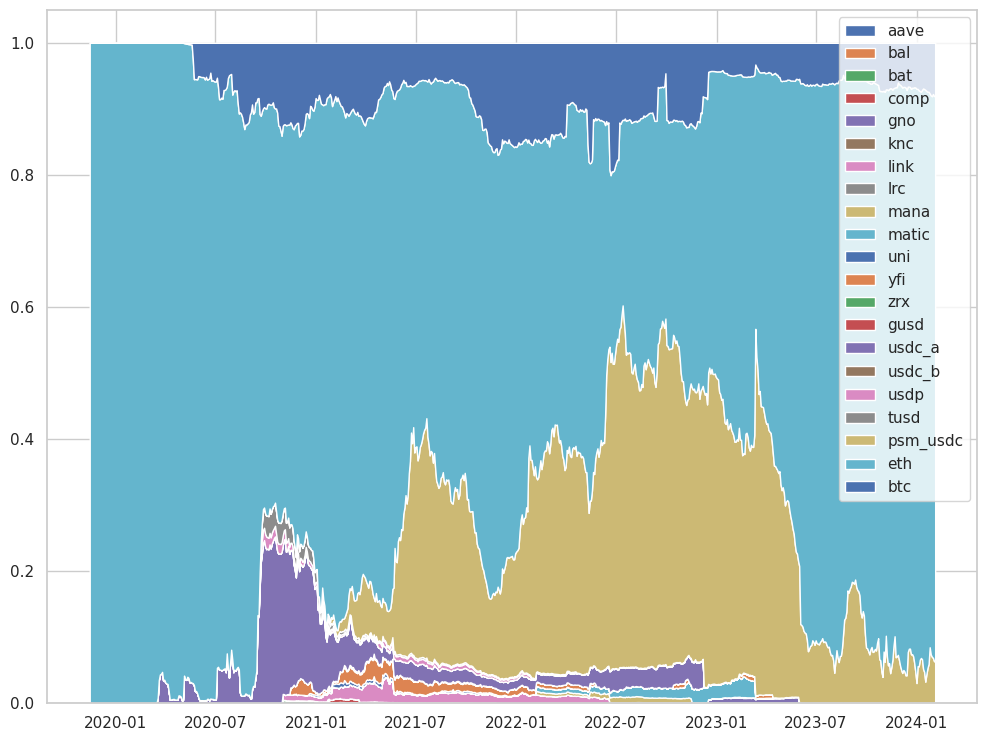

In [46]:
# dai_data.plot()
def plot_stack(data):
    plt.stackplot(data.index, (data.values / np.expand_dims(data.values.sum(axis=1), axis=-1)).T, labels=data.columns)
    plt.legend()
    plt.show()

plot_stack(dai_data)

In [47]:
cols = [c for c in dai_data.columns if c.upper() in returns.columns]
df = dai_data[cols][dai_data[cols].sum(axis=1) > 0]
df

print(df.sum())
dist1 = df.sum(axis=0) / df.to_numpy().sum()
print("d1", dist1.to_dict())
dist2 = (df / df.sum(axis=1).to_numpy()[:,np.newaxis]).sum(axis=0) / len(df)
dist2 = dist2 / dist2.sum()
print("d2", dist2.to_dict())

bat      1.465333e+09
link     4.480205e+10
matic    2.131049e+10
zrx      1.330904e+09
eth      3.035302e+12
btc      4.999166e+11
dtype: float64
d1 {'bat': 0.00040657083681778524, 'link': 0.012430761121125641, 'matic': 0.0059128013570397585, 'zrx': 0.0003692720602814699, 'eth': 0.8421739022824656, 'btc': 0.13870669234226987}
d2 {'bat': 0.00040672296432126356, 'link': 0.00729003212199598, 'matic': 0.00682851939787407, 'zrx': 0.00023414520630679072, 'eth': 0.8715032039293353, 'btc': 0.11373737638016655}


In [34]:
def min_volatility_portfolio(returns, max_percentage=1):
    # Calculate expected returns and sample covariance
    mu = expected_returns.mean_historical_return(
        returns, returns_data=True, frequency=FREQUENCY
    )
    # cov = risk_models.sample_cov(returns, returns_data=True, frequency=frequency)
    cov = risk_models.CovarianceShrinkage(
        returns, returns_data=True, frequency=FREQUENCY
    ).ledoit_wolf()

    # Here we can control the maximum percentage per one asset
    ef = EfficientFrontier(
        mu,
        cov,
        weight_bounds=(0, max_percentage),
        solver="SCS",
        solver_options={"eps_abs": 1e-10},
    )
    _ = ef.min_volatility()
    cleaned_weights = ef.clean_weights()
    portfolio = {k: v for k, v in cleaned_weights.items()}
    print(portfolio)

    ef.portfolio_performance(verbose=True)

    return portfolio

## Optimizing knowing future volatility

In [35]:
def portfolio_composition(horizon, offset, step=DAILY_FREQUENCY):
    """Compute portfolio composition over the returns.
    
    Args:
        step: step size determining how often we compute portfolio (default each day)
        horizon: how many returns are used for optimization
        offset: offset position of returns used for optimization
            (use negative offset values to optimize using past data)
    """
    cols = [c.upper() for c in dai_data.columns if c.upper() in returns.columns]
    rets = returns[cols]

    results = []
    indexes = []

    for i in range(offset, len(rets), step):
        indexes.append(rets.index[i])
        portfolio = min_volatility_portfolio(rets.iloc[i - offset:i + horizon - offset])
        results.append(portfolio)    

    res_df = pd.DataFrame(results, index=indexes)
    res_df.to_csv(f"../output/composition_{horizon / DAILY_FREQUENCY}days_{'past' if offset > 0 else 'future'}.csv")
    plot_stack(res_df)

here
{'BAT': 0.15563, 'LINK': 0.03066, 'MATIC': 0.01302, 'ZRX': 0.17561, 'ETH': 0.10902, 'BTC': 0.51606}
Expected annual return: 56160.4%
Annual volatility: 71.7%
Sharpe Ratio: 782.80
here
{'BAT': 0.16229, 'LINK': 0.03286, 'MATIC': 0.01654, 'ZRX': 0.18272, 'ETH': 0.10571, 'BTC': 0.49989}
Expected annual return: 51226.6%
Annual volatility: 72.3%
Sharpe Ratio: 708.31
here
{'BAT': 0.18534, 'LINK': 0.03685, 'MATIC': 0.02463, 'ZRX': 0.20276, 'ETH': 0.11039, 'BTC': 0.44003}
Expected annual return: 105629.3%
Annual volatility: 75.2%
Sharpe Ratio: 1404.52
here
{'BAT': 0.19327, 'LINK': 0.03837, 'MATIC': 0.02655, 'ZRX': 0.21225, 'ETH': 0.11808, 'BTC': 0.41148}
Expected annual return: 177296.3%
Annual volatility: 77.1%
Sharpe Ratio: 2299.64
here
{'BAT': 0.19774, 'LINK': 0.03882, 'MATIC': 0.02934, 'ZRX': 0.2119, 'ETH': 0.12234, 'BTC': 0.39986}
Expected annual return: 2224466.8%
Annual volatility: 77.5%
Sharpe Ratio: 28685.98
here
{'BAT': 0.19392, 'LINK': 0.03707, 'MATIC': 0.02953, 'ZRX': 0.21856, 

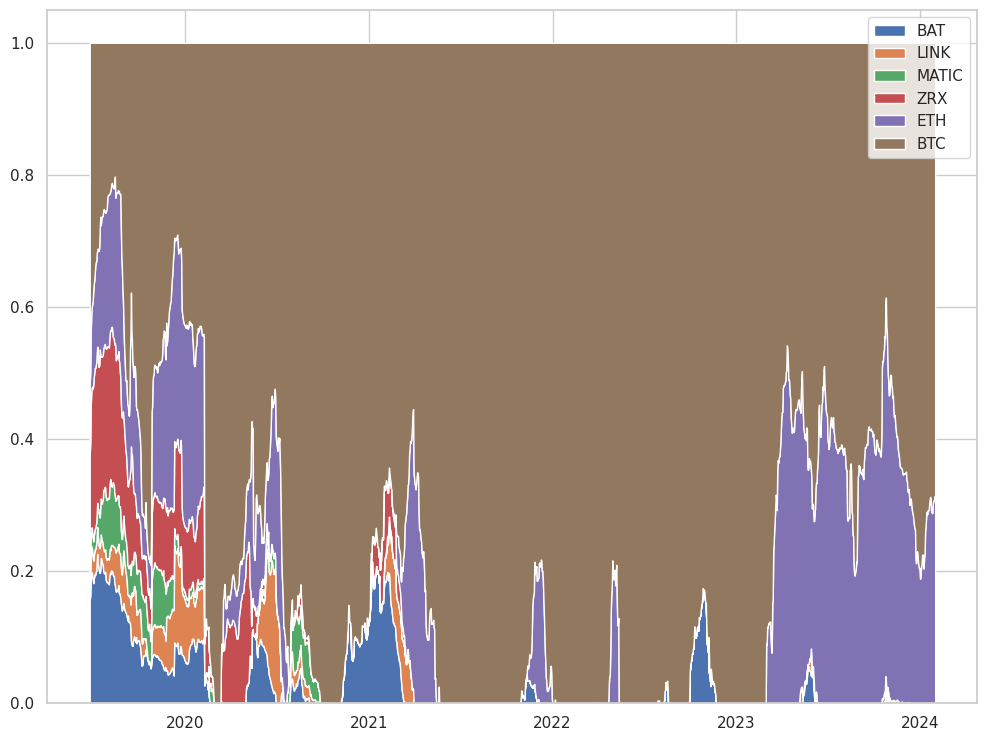

In [36]:
portfolio_composition(DAILY_FREQUENCY * 60, DAILY_FREQUENCY * 60)

here
{'BAT': 0.13902, 'LINK': 0.04464, 'MATIC': 0.03841, 'ZRX': 0.15079, 'ETH': 0.16429, 'BTC': 0.46285}
Expected annual return: 209.0%
Annual volatility: 70.6%
Sharpe Ratio: 2.93
here
{'BAT': 0.13939, 'LINK': 0.04467, 'MATIC': 0.03931, 'ZRX': 0.15101, 'ETH': 0.16388, 'BTC': 0.46174}
Expected annual return: 223.8%
Annual volatility: 70.5%
Sharpe Ratio: 3.15
here
{'BAT': 0.14059, 'LINK': 0.04451, 'MATIC': 0.0392, 'ZRX': 0.15035, 'ETH': 0.1645, 'BTC': 0.46085}
Expected annual return: 236.2%
Annual volatility: 70.5%
Sharpe Ratio: 3.32
here
{'BAT': 0.13999, 'LINK': 0.04487, 'MATIC': 0.03959, 'ZRX': 0.15057, 'ETH': 0.16493, 'BTC': 0.46005}
Expected annual return: 239.0%
Annual volatility: 70.6%
Sharpe Ratio: 3.36
here
{'BAT': 0.14061, 'LINK': 0.04496, 'MATIC': 0.04111, 'ZRX': 0.15047, 'ETH': 0.16421, 'BTC': 0.45864}
Expected annual return: 212.0%
Annual volatility: 70.5%
Sharpe Ratio: 2.98
here
{'BAT': 0.13991, 'LINK': 0.04497, 'MATIC': 0.0416, 'ZRX': 0.15065, 'ETH': 0.16493, 'BTC': 0.45792

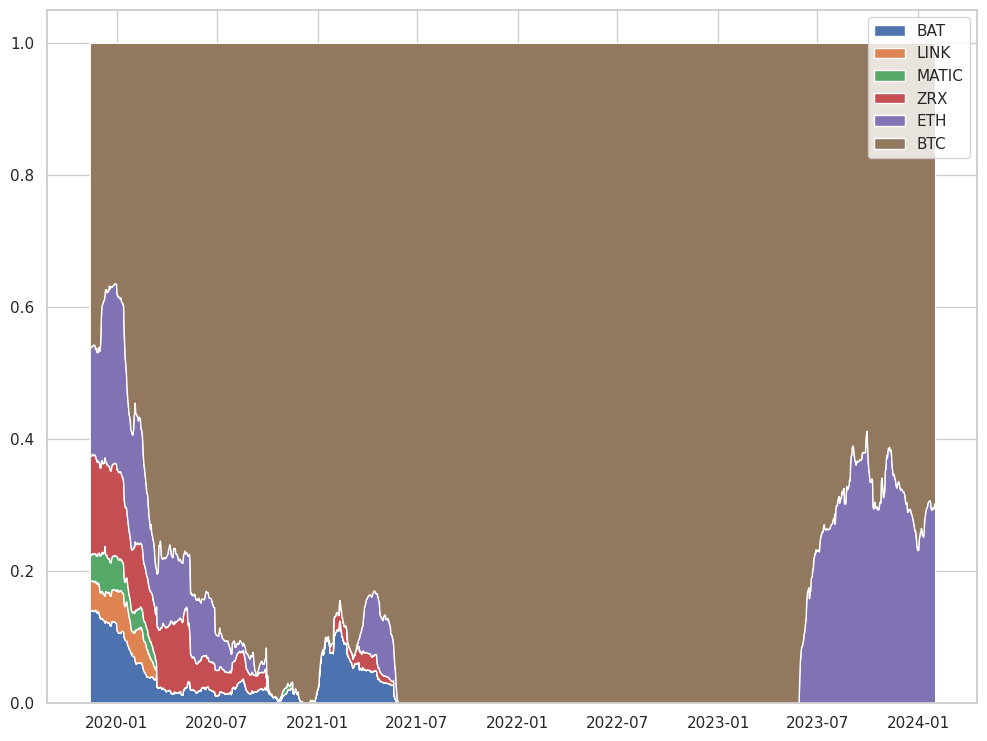

In [37]:
portfolio_composition(DAILY_FREQUENCY * 200, DAILY_FREQUENCY * 200)

here
{'BAT': 0.11899, 'LINK': 0.03992, 'MATIC': 0.0, 'ZRX': 0.11398, 'ETH': 0.0, 'BTC': 0.7271}
Expected annual return: 196252.5%
Annual volatility: 72.3%
Sharpe Ratio: 2713.29
here
{'BAT': 0.13516, 'LINK': 0.04675, 'MATIC': 0.0, 'ZRX': 0.12858, 'ETH': 0.0, 'BTC': 0.6895}
Expected annual return: 296542.4%
Annual volatility: 74.4%
Sharpe Ratio: 3986.95
here
{'BAT': 0.14321, 'LINK': 0.04281, 'MATIC': 0.00035, 'ZRX': 0.12219, 'ETH': 0.0, 'BTC': 0.69143}
Expected annual return: 12526760.6%
Annual volatility: 74.8%
Sharpe Ratio: 167358.93
here
{'BAT': 0.14471, 'LINK': 0.04319, 'MATIC': 0.0014, 'ZRX': 0.1214, 'ETH': 0.0, 'BTC': 0.68931}
Expected annual return: 296122535.9%
Annual volatility: 75.1%
Sharpe Ratio: 3940585.17
here
{'BAT': 0.14639, 'LINK': 0.04545, 'MATIC': 0.003, 'ZRX': 0.12115, 'ETH': 0.0, 'BTC': 0.68401}
Expected annual return: 51313499.1%
Annual volatility: 75.2%
Sharpe Ratio: 682442.59
here
{'BAT': 0.1425, 'LINK': 0.03978, 'MATIC': 0.00276, 'ZRX': 0.1124, 'ETH': 0.0, 'BTC': 

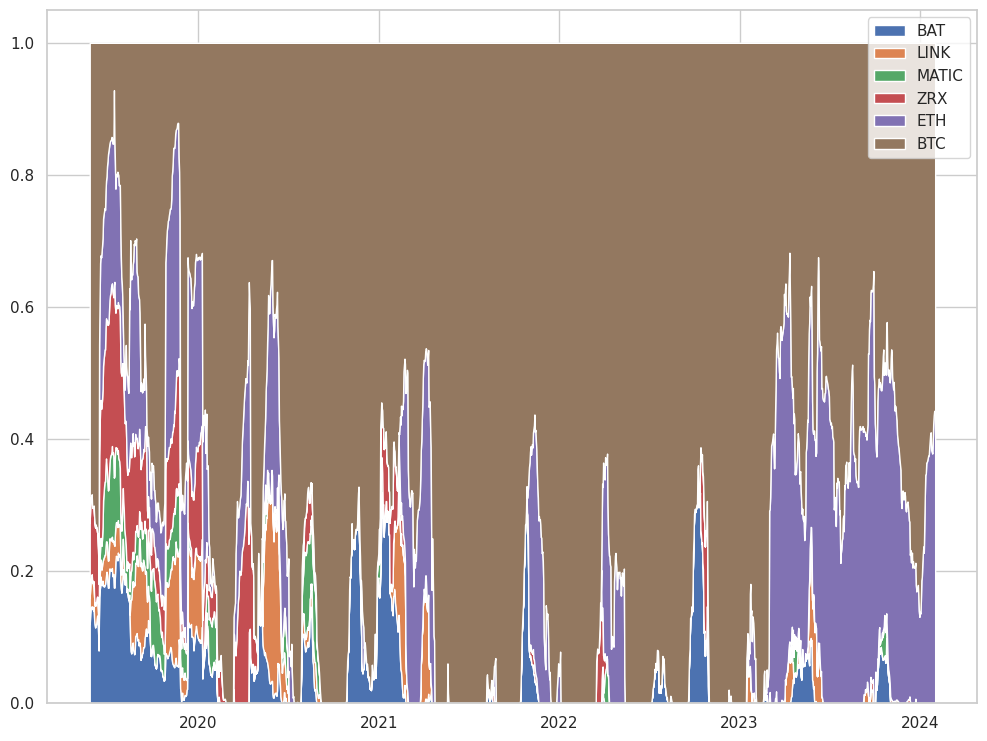

In [38]:
portfolio_composition(DAILY_FREQUENCY * 30, DAILY_FREQUENCY * 30)

here
{'BAT': 0.11899, 'LINK': 0.03992, 'MATIC': 0.0, 'ZRX': 0.11398, 'ETH': 0.0, 'BTC': 0.7271}
Expected annual return: 196252.5%
Annual volatility: 72.3%
Sharpe Ratio: 2713.29
here
{'BAT': 0.13516, 'LINK': 0.04675, 'MATIC': 0.0, 'ZRX': 0.12858, 'ETH': 0.0, 'BTC': 0.6895}
Expected annual return: 296542.4%
Annual volatility: 74.4%
Sharpe Ratio: 3986.95
here
{'BAT': 0.14321, 'LINK': 0.04281, 'MATIC': 0.00035, 'ZRX': 0.12219, 'ETH': 0.0, 'BTC': 0.69143}
Expected annual return: 12526760.6%
Annual volatility: 74.8%
Sharpe Ratio: 167358.93
here
{'BAT': 0.14471, 'LINK': 0.04319, 'MATIC': 0.0014, 'ZRX': 0.1214, 'ETH': 0.0, 'BTC': 0.68931}
Expected annual return: 296122535.9%
Annual volatility: 75.1%
Sharpe Ratio: 3940585.17
here
{'BAT': 0.14639, 'LINK': 0.04545, 'MATIC': 0.003, 'ZRX': 0.12115, 'ETH': 0.0, 'BTC': 0.68401}
Expected annual return: 51313499.1%
Annual volatility: 75.2%
Sharpe Ratio: 682442.59
here
{'BAT': 0.1425, 'LINK': 0.03978, 'MATIC': 0.00276, 'ZRX': 0.1124, 'ETH': 0.0, 'BTC': 

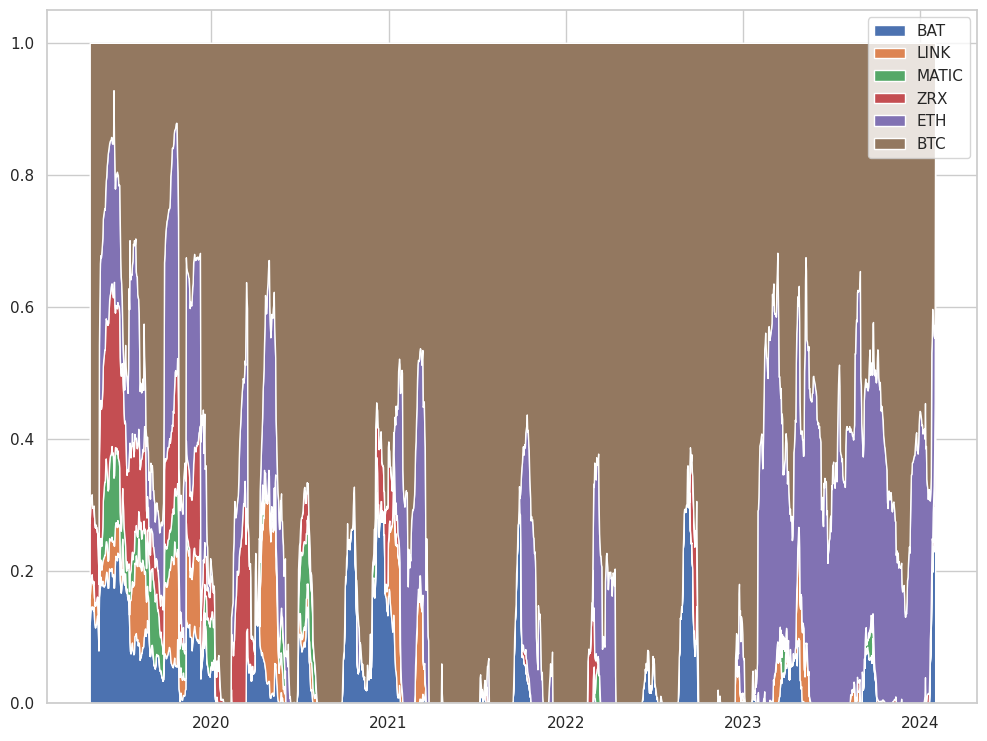

In [39]:
portfolio_composition(DAILY_FREQUENCY * 30, 0)

here
{'BAT': 0.15563, 'LINK': 0.03066, 'MATIC': 0.01302, 'ZRX': 0.17561, 'ETH': 0.10902, 'BTC': 0.51606}
Expected annual return: 56160.4%
Annual volatility: 71.7%
Sharpe Ratio: 782.80
here
{'BAT': 0.16229, 'LINK': 0.03286, 'MATIC': 0.01654, 'ZRX': 0.18272, 'ETH': 0.10571, 'BTC': 0.49989}
Expected annual return: 51226.6%
Annual volatility: 72.3%
Sharpe Ratio: 708.31
here
{'BAT': 0.18534, 'LINK': 0.03685, 'MATIC': 0.02463, 'ZRX': 0.20276, 'ETH': 0.11039, 'BTC': 0.44003}
Expected annual return: 105629.3%
Annual volatility: 75.2%
Sharpe Ratio: 1404.52
here
{'BAT': 0.19327, 'LINK': 0.03837, 'MATIC': 0.02655, 'ZRX': 0.21225, 'ETH': 0.11808, 'BTC': 0.41148}
Expected annual return: 177296.3%
Annual volatility: 77.1%
Sharpe Ratio: 2299.64
here
{'BAT': 0.19774, 'LINK': 0.03882, 'MATIC': 0.02934, 'ZRX': 0.2119, 'ETH': 0.12234, 'BTC': 0.39986}
Expected annual return: 2224466.8%
Annual volatility: 77.5%
Sharpe Ratio: 28685.98
here
{'BAT': 0.19392, 'LINK': 0.03707, 'MATIC': 0.02953, 'ZRX': 0.21856, 

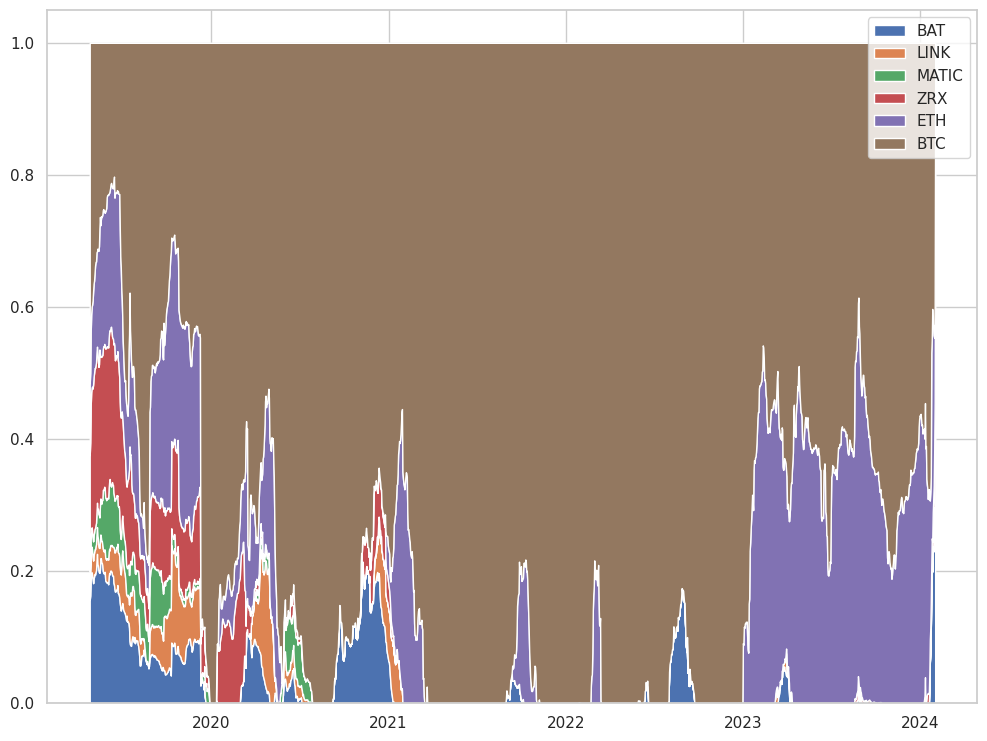

In [40]:
portfolio_composition(DAILY_FREQUENCY * 60, 0)

here
{'BAT': 0.13902, 'LINK': 0.04464, 'MATIC': 0.03841, 'ZRX': 0.15079, 'ETH': 0.16429, 'BTC': 0.46285}
Expected annual return: 209.0%
Annual volatility: 70.6%
Sharpe Ratio: 2.93
here
{'BAT': 0.13939, 'LINK': 0.04467, 'MATIC': 0.03931, 'ZRX': 0.15101, 'ETH': 0.16388, 'BTC': 0.46174}
Expected annual return: 223.8%
Annual volatility: 70.5%
Sharpe Ratio: 3.15
here
{'BAT': 0.14059, 'LINK': 0.04451, 'MATIC': 0.0392, 'ZRX': 0.15035, 'ETH': 0.1645, 'BTC': 0.46085}
Expected annual return: 236.2%
Annual volatility: 70.5%
Sharpe Ratio: 3.32
here
{'BAT': 0.13999, 'LINK': 0.04487, 'MATIC': 0.03959, 'ZRX': 0.15057, 'ETH': 0.16493, 'BTC': 0.46005}
Expected annual return: 239.0%
Annual volatility: 70.6%
Sharpe Ratio: 3.36
here
{'BAT': 0.14061, 'LINK': 0.04496, 'MATIC': 0.04111, 'ZRX': 0.15047, 'ETH': 0.16421, 'BTC': 0.45864}
Expected annual return: 212.0%
Annual volatility: 70.5%
Sharpe Ratio: 2.98
here
{'BAT': 0.13991, 'LINK': 0.04497, 'MATIC': 0.0416, 'ZRX': 0.15065, 'ETH': 0.16493, 'BTC': 0.45792

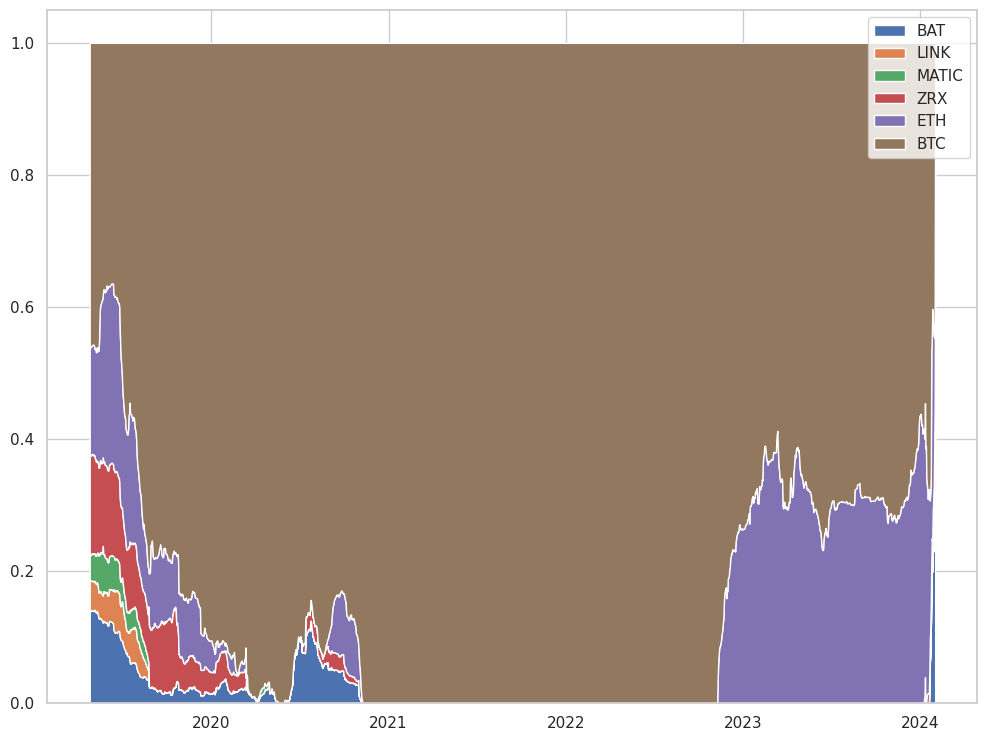

In [41]:
portfolio_composition(DAILY_FREQUENCY * 200, 0)